This notebooks aims to try neural networks with different balancing methods to improve performance on valid dataset

In [54]:
import pandas as pd 
import imblearn
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# neural networks import 

from tensorflow_addons import losses
import tensorflow as tf
from tensorflow import keras

In [55]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Since it is recommended by author of SMOTE that both oversampling and undersampling are undertaken in the sampe 
experiment, that's the methodology we are following here

In [4]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter # instead of value counts
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [72]:
data = pd.read_csv('../../trial/DS-Teams-Project-2/individuals16.csv', index_col = 0)

In [66]:
X = data.drop(['label', 'indiv'], axis = 1)
y = data.label

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [68]:
X_train.head()

,cust_in_top_10_sales,store_top_tran,store_top_tires_tran,vehicle_tire_svc,vhc_tire_purchase,vhc_early_tire_purchase,top_cust_overall,top_cust_tire_purch,indiv_make_tire_pch,make_prop_tire,MODEL_prop_tire,SUB_MODEL_prop_tire
230244,0,1,1,1,1,0,0,1,1,0,0,0
2812530,0,1,1,0,0,0,0,0,0,0,0,0
2907175,0,1,1,0,0,0,0,0,1,0,0,0
482217,0,1,1,1,1,1,0,1,1,0,0,0
959433,0,1,1,1,0,0,0,0,1,0,0,0


### summarize class distribution

In [69]:
counter = Counter(y_train)
print(counter)

Counter({0: 2324289, 1: 77063})


### define pipeline

In [10]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [70]:
# over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

### summarize the new class distribution

In [71]:
counter = Counter(y_train)
print(counter)

Counter({0: 77063, 1: 77063})


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of an individual purchasing in November

In [30]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(12,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [31]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [32]:
model = make_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                208       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.predict(X_train)

array([[0.41350043],
       [0.4133214 ],
       [0.4155759 ],
       ...,
       [0.4133214 ],
       [0.4133214 ],
       [0.4133214 ]], dtype=float32)

In [36]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7182


In [37]:
initial_bias = np.log([1/2])
initial_bias

array([-0.69314718])

In [39]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

array([[0.19599819],
       [0.15388465],
       [0.10430256],
       [0.10874048],
       [0.10430256],
       [0.15545857],
       [0.11570534],
       [0.11882457],
       [0.19599819],
       [0.15388465]], dtype=float32)

In [40]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7884


In [45]:
import os, tempfile

In [47]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [49]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=0)

In [50]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=0)

In [56]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

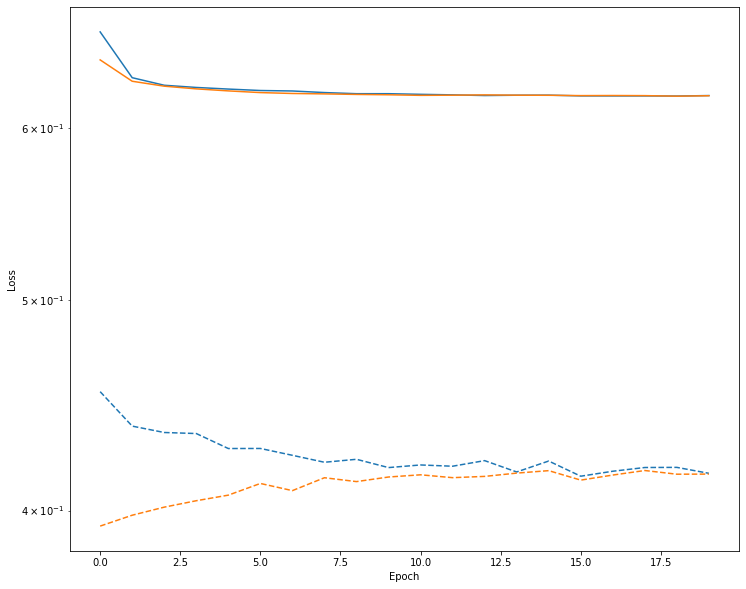

In [59]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [62]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test))

Epoch 1/100
113/113 [==============================] - 27s 226ms/step - loss: 0.6454 - tp: 1139.0000 - fp: 7964.0000 - tn: 727234.0000 - fn: 95190.0000 - accuracy: 0.8759 - precision: 0.1251 - recall: 0.0118 - auc: 0.4939 - prc: 0.1181 - val_loss: 0.3936 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 581072.0000 - val_fn: 19266.0000 - val_accuracy: 0.9679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5929 - val_prc: 0.0421
Epoch 2/100
113/113 [==============================] - 1s 11ms/step - loss: 0.6306 - tp: 2011.0000 - fp: 2502.0000 - tn: 151624.0000 - fn: 75052.0000 - accuracy: 0.6645 - precision: 0.4456 - recall: 0.0261 - auc: 0.5760 - prc: 0.3858 - val_loss: 0.3926 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 581072.0000 - val_fn: 19266.0000 - val_accuracy: 0.9679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6073 - val_prc: 0.0444
Epoch 3/100
113/113 [==============================] - 1s 11ms/step - loss: 0.6268 - tp: 2436.0000

Epoch 20/100
113/113 [==============================] - 1s 11ms/step - loss: 0.6205 - tp: 4941.0000 - fp: 4567.0000 - tn: 149559.0000 - fn: 72122.0000 - accuracy: 0.6683 - precision: 0.5197 - recall: 0.0641 - auc: 0.6081 - prc: 0.4254 - val_loss: 0.4157 - val_tp: 760.0000 - val_fp: 7270.0000 - val_tn: 573802.0000 - val_fn: 18506.0000 - val_accuracy: 0.9571 - val_precision: 0.0946 - val_recall: 0.0394 - val_auc: 0.6129 - val_prc: 0.0495
Epoch 21/100
113/113 [==============================] - 1s 12ms/step - loss: 0.6209 - tp: 4296.0000 - fp: 3925.0000 - tn: 150201.0000 - fn: 72767.0000 - accuracy: 0.6683 - precision: 0.5226 - recall: 0.0557 - auc: 0.6082 - prc: 0.4244 - val_loss: 0.4172 - val_tp: 760.0000 - val_fp: 7270.0000 - val_tn: 573802.0000 - val_fn: 18506.0000 - val_accuracy: 0.9571 - val_precision: 0.0946 - val_recall: 0.0394 - val_auc: 0.6128 - val_prc: 0.0495
Epoch 22/100
113/113 [==============================] - 1s 11ms/step - loss: 0.6208 - tp: 4643.0000 - fp: 4271.0000 - tn

## I will try this tutorial   

# https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [74]:
train, val, test = np.split(data.sample(frac=1), [int(0.8*len(data)), int(0.9*len(data))])

In [75]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2401352 training examples
300169 validation examples
300169 test examples


In [83]:
def df_to_dataset(data, shuffle=True, batch_size=32):
  df = data.copy()
  labels = df.pop('label')
  df = {key: value[:,tf.newaxis] for key, value in data.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(data))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [98]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)


/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [99]:
val_ds = df_to_dataset(val, batch_size=batch_size)

/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [100]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
# print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['indiv', 'label', 'cust_in_top_10_sales', 'store_top_tran', 'store_top_tires_tran', 'vehicle_tire_svc', 'vhc_tire_purchase', 'vhc_early_tire_purchase', 'top_cust_overall', 'top_cust_tire_purch', 'indiv_make_tire_pch', 'make_prop_tire', 'MODEL_prop_tire', 'SUB_MODEL_prop_tire']
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


In [101]:
model = keras.Sequential([
      keras.layers.Dense(
          32, activation='relu',
          input_shape=(12,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics='precision')


In [106]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 5.5 kB/s  eta 0:00:01     |████████████▌                   | 194.7 MB 23.6 MB/s eta 0:00:13     |██████████████████▉             | 292.0 MB 29.3 MB/s eta 0:00:08     |███████████████████▋            | 304.6 MB 23.2 MB/s eta 0:00:09     |█████████████████████▎          | 331.5 MB 23.2 MB/s eta 0:00:08     |████████████████████████▍       | 380.0 MB 21.8 MB/s eta 0:00:06     |███████████████████████████▊    | 431.2 MB 28.2 MB/s eta 0:00:03     |█████████████████████████████▍  | 457.3 MB 18.5 MB/s eta 0:00:03     |████████████████████████████████| 496.1 MB 15.8 MB/s eta 0:00:01


In [105]:

# model.fit(train_ds, epochs=1, validation_data=val_ds)

fits = model.fit(
    train_ds,
    epochs = 1,
    validation_data=val_ds,
    verbose=0)

ValueError: in user code:

    File "/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/keras/engine/input_spec.py", line 183, in assert_input_compatibility
        raise ValueError(f'Missing data for input "{name}". '

    ValueError: Missing data for input "dense_46_input". You passed a data dictionary with keys ['MODEL_prop_tire', 'SUB_MODEL_prop_tire', 'cust_in_top_10_sales', 'indiv', 'indiv_make_tire_pch', 'label', 'make_prop_tire', 'store_top_tires_tran', 'store_top_tran', 'top_cust_overall', 'top_cust_tire_purch', 'vehicle_tire_svc', 'vhc_early_tire_purchase', 'vhc_tire_purchase']. Expected the following keys: ['dense_46_input']


In [28]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(12, input_dim=12, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=1)
    else:
        model.fit(X_train, y_train, epochs=1, class_weight = [1, 0.01])
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

In [29]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

18761/18761 [==============================] - 29s 2ms/step - loss: 0.4428 - accuracy: 0.8887
[0.44283953309059143, 0.8887393474578857]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94    581072
           1       0.06      0.17      0.09     19266

    accuracy                           0.89    600338
   macro avg       0.52      0.54      0.51    600338
weighted avg       0.94      0.89      0.91    600338



## Mitigating Skewdness of Data
reference: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

### Method1: Undersampling

In [16]:
# Class count
count_class_0, count_class_1 = y_train.value_counts()

# Divide by class
# df_class_0 = df2[df2['Churn'] == 0]
# df_class_1 = df2[df2['Churn'] == 1]

(389318, 194659)

In [221]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
1    1869
0    1869
Name: Churn, dtype: int64


In [222]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [223]:
# Number of classes in training Data
y_train.value_counts()

1    1495
0    1495
Name: Churn, dtype: int64

#### Applying Logistic Regression

In [224]:
weights = -1 # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.7513368983957219 

preds [0 1 0 1 0] 

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       374
           1       0.74      0.77      0.76       374

    accuracy                           0.75       748
   macro avg       0.75      0.75      0.75       748
weighted avg       0.75      0.75      0.75       748



<h4 style='color:blue'>With undersampling: f1 score for minority class 1 improved to be 0.75 from 0.59</h4>

### Method2: Oversampling

In [225]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
1    5163
0    5163
Name: Churn, dtype: int64


In [226]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [227]:
# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

#### Logistic Regression

In [228]:
weights = -1 # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.7783155856727977 

preds [1 0 1 1 0] 

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1033
           1       0.75      0.84      0.79      1033

    accuracy                           0.78      2066
   macro avg       0.78      0.78      0.78      2066
weighted avg       0.78      0.78      0.78      2066



<h4 style='color:blue'>With oversampling: f1 score for minority class 1 improved to be 0.76 from 0.59</h4>

### Method3: SMOTE

To install imbalanced-learn library use "pip install imbalanced-learn" command

In [229]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [230]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

y_sm.value_counts()

1    5163
0    5163
Name: Churn, dtype: int64

In [231]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [232]:
# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

#### Logistic Regression

In [233]:
weights = -1 # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.8000968054211036 

preds [1 0 1 1 0] 

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1033
           1       0.78      0.83      0.81      1033

    accuracy                           0.80      2066
   macro avg       0.80      0.80      0.80      2066
weighted avg       0.80      0.80      0.80      2066



<h4 style='color:blue'>With SMOTE oversampling: f1 score for minority class 1 improved to be 0.81 from 0.59</h4>

### Method4: Use of Ensemble with undersampling

In [234]:
df2.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [235]:
# Regain Original features and labels
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [236]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [237]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

model1 --> class1(1495) + class0(0, 1495)

model2 --> class1(1495) + class0(1496, 2990)

model3 --> class1(1495) + class0(2990, 4130)

In [238]:
model = LogisticRegression()

df3 = X_train.copy()
df3['Churn'] = y_train

In [239]:
df3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
684,1,0,0,0,0.000000,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2446,1,0,0,0,0.239437,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
1680,0,0,1,1,0.774648,1,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2220,0,0,1,0,1.000000,1,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
2842,1,0,0,0,0.042254,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


In [240]:
df3_class0 = df3[df3.Churn==0]
df3_class1 = df3[df3.Churn==1]

In [241]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)
    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train    

In [242]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)

model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

In [243]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

model2 = LogisticRegression()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [244]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

model3 = LogisticRegression()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

In [245]:
len(y_pred1)

1407

In [246]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [247]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407



f1-score for minority class 1 improved to 0.62 from 0.57. The score for majority class 0 is suffering and reduced to 0.80 from 0.85 but at least there is some balance in terms of prediction accuracy across two classes